# Notebook with examples on Ch.11. Data Leakage

Things I want to show:
1. Bad controls induce data leakage
2. Leaking moments from incorrect standardization
3. Classification models with quasi-complete separation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.pyplot import cm
import matplotlib.colors as colors
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn import metrics
import cycler


# set plotting parameters from the beginning
font = {'family' : 'monospace',
        'weight' : 'normal',
        'size'   : 14}
axes = {'titlesize' : 22,
        'labelsize' : 20,
       'prop_cycle' : cycler.cycler(color='k')}
lines = {'color' : 'k'}
figure = {'figsize' : (10,4),
         'autolayout' : True,}
matplotlib.rc('font', **font)
matplotlib.rc('axes', **axes)
matplotlib.rc('figure', **figure)
matplotlib.rc('lines', **lines)


In [2]:
def percentile(n):
    """
    Percentile function to pass to Pandas agg method
    Taken from: https://stackoverflow.com/questions/17578115/pass-percentiles-to-pandas-agg-function
        Note that top answer doesn't work well to handle multiple columns so I used a proposed fix in
        the thread (Thomas) that uses Pandas quantile method that works on any series
    """
    def percentile_(x):
        return x.quantile(n)
    percentile_.__name__ = 'percentile_{:2.0f}'.format(n*100)
    return percentile_

def create_means_bounds_mc(df, qmin = 0.05, qmax = 0.95):
    """
    Helper function to get the means and bounds for the plot_conf_intervals method
    df: dataframe with the results from the MonteCarlo simulation
    qmin, qmax: quantiles to create the CI (default is 90% CI)
    """
    df_agg = df.agg([np.mean, percentile(qmin), percentile(qmax)])
    return df_agg

def plot_conf_intervals(means, bounds, var_labels, ax, true_params = None, plot_bars = True):
    """
    Plot standard confidence intervals.  Box plots do the job, but this is more general function
        means: array: has the means to be plotted (could be estimated parameters)
        bounds: array: lower and upper bounds for the CI (size: 2 x number of columns)
        var_labels: 
        ax: axis object to create the plot
        true_params: array with true parameters if I want to plot them along (default: None)
        plot_bars: Boolean: if True: plot the bars, False: just plot the CI and means as marker
            Bars may unnecessarily clutter the plot (see first example below)
    Output:
        axis object with the plot
    """
    # check dimensions first
    if len(means)!=bounds.shape[1] or len(var_labels)!=len(means):
        raise ValueError("You must pass the same number of variables for means and bounds")
    # plot means as bars, confidence intervals as lines
    n_bars = len(means)
    width = 0.5
    G = 0.2*width # parameter to control the width of the CI
    if plot_bars:
        ax.bar(range(n_bars), means, color ='0.75', edgecolor = 'k', width = width, alpha = 0.5, 
              label='means')
    else:
        #x_scatter = [i-G*0.5 for i in range(n_bars)]
        #ax.scatter(x_scatter, means, color = '0.5', edgecolor = 'k', marker = '.', s = 30, 
        #      label='means')
        for i in range(n_bars):
            if i==0:
                ax.plot([i-G*0.5, i+G*0.5], [means[i], means[i]], color='k',ls='--', label='means')
            else:
                ax.plot([i-G*0.5, i+G*0.5], [means[i], means[i]], color='k',ls='--')
                
    for i in range(n_bars):
        ymin_i, ymax_i = bounds[:,i]
        if i==0:
            ax.plot([i, i], [ymin_i, ymax_i], color ='k', alpha = 1, label='CI')
        else:
            ax.plot([i, i], [ymin_i, ymax_i], color ='k', alpha = 1)
        ax.plot([i-G, i+G], [ymin_i, ymin_i], color ='k', alpha = 1, lw = 1)
        ax.plot([i-G, i+G], [ymax_i, ymax_i], color ='k', alpha = 1, lw = 1)
    # pass labels
    ax.set_xticks(range(n_bars))
    ax.set_xticklabels(var_labels)
    # plot true parameters
    if true_params is not None:
        x_scatter_p = [i+G*0.5 for i in range(n_bars)]  # to improve visibility
        ax.scatter(x_scatter_p, true_params, marker = 's', color = 'k', s=30,
              label='true')
        
    xmin, xmax = ax.get_xlim()
    ax.plot([xmin, xmax], [0, 0], ls = '--', color = '0.2')
    ax.set_xlim([xmin, xmax]) # just to make the plot nicer: enforce plot's width
    ax.legend()
    return ax

# Typical scenario

$$
\begin{eqnarray}
y_t &=& f(\bf{x}_{t-1}) + \epsilon_t \\
z_{t} &=& g(y_t) + \eta_t
\end{eqnarray}
$$
we run a regression of $y_t$ on $x_{t-1}, z_t$

In [3]:
def simulate_ar1_process(nobs, rho, seed, lab = 'y', trend = None):
    "Simulate a simple AR1 process: y_t = rho*y_{t-1} + noise_t"
    np.random.seed(seed)
    noise = np.random.randn(nobs)
    df_y = pd.DataFrame(index=range(nobs), columns = [lab])
    alpha_trend = 0
    if trend is not None:
        alpha_trend = trend
    for t in range(nobs):
        if t==0:
            df_y[lab].loc[t] = noise[t]
        else:
            df_y[lab].loc[t] = rho*df_y[lab].loc[t-1] + alpha_trend*t + noise[t]
    return df_y

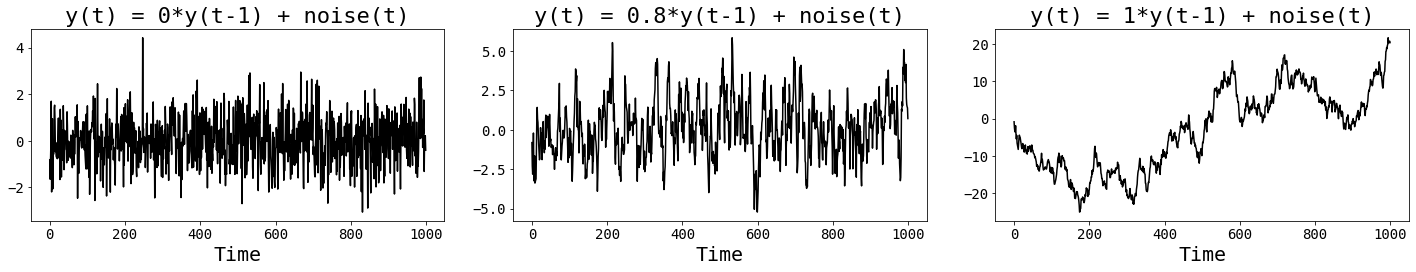

In [4]:
# test with some common examples
rho_grid = [0, 0.8, 1]
nobs = int(1e3)
seed = 52105
fig, ax = plt.subplots(1,3, figsize = (20,4))
for r, rho_r in enumerate(rho_grid):
    y_r = simulate_ar1_process(nobs=nobs, rho=rho_r, seed=seed)
    y_r.y.plot(ax=ax[r])
    ax[r].set_title(f'y(t) = {rho_r}*y(t-1) + noise(t)')
    ax[r].set_xlabel('Time')

In [5]:
def clean_nans(y,x):
    "Drop NaNs from y and x and keep common set of observations"
    cols_y = y.columns
    cols_x = x.columns
    cat_df = pd.concat((y,x), axis=1).dropna()
    y_nan = cat_df[cols_y]
    x_nan = cat_df[cols_x]
    return y_nan, x_nan

x = pd.DataFrame(np.random.randn(2), columns=['x'])
x_lag = (x.shift(1)).rename(columns={'x':'xlag'})
new_x, new_lag = clean_nans(x, x_lag)
new_x, new_lag

(          x
 1  1.601471,
        xlag
 1  0.864914)

In [6]:
def compute_mse_ols(xdf, ydf):
    "Run OLS and compute MSE on test sample"
    x_train, x_test, y_train, y_test = train_test_split(xdf, ydf, random_state=0)
    reg = LinearRegression().fit(x_train, y_train.values.flatten())
    y_hat = reg.predict(x_test)
    mse = mean_squared_error(y_test, y_hat)
    return mse

In [7]:
def run_mc_leakage1(rho_x, alpha, beta, var_dict, nobs, seed_mc, num_montecarlo):
    "MC to test the extent of leakage problem"
    np.random.seed(seed_mc)
    seed_arr = np.random.randint(low=1, high=10000, size=num_montecarlo, dtype=int)
    df_mse = pd.DataFrame(index=range(num_montecarlo), columns = ['mse_noleak', 'mse_leak'])
    var_y = var_dict['var_y']
    var_z = var_dict['var_z']
    a0, a1 = alpha
    b0, b1 = beta
    for i in range(num_montecarlo):
        seed_i = seed_arr[i]
        x = simulate_ar1_process(nobs=nobs, rho=rho_x, seed=seed_i, lab = 'x')
        y = a0 + a1*x.shift(1) + np.sqrt(var_y)*np.random.randn(nobs,1)
        y.rename(columns={'x':'y'}, inplace=True)
        z = b0 + b1*y + np.sqrt(var_z)*np.random.randn(nobs,1)
        z.rename(columns={'y':'z'}, inplace=True)
        # I want to run two exercises: no data leakage & data leakage
        # No leakage
        xlag = x.shift(1)
        ydf, xdf = clean_nans(y,xlag)
        mse_nl = compute_mse_ols(xdf = xdf, ydf = ydf)
        # Leakage
        feat_df = xlag
        feat_df['z'] = z.values.flatten()
        ydf, xdf = clean_nans(y,feat_df)
        mse_l = compute_mse_ols(xdf = xdf, ydf = ydf)
        df_mse.loc[i] = [mse_nl, mse_l]
    return df_mse

In [8]:
def plot_mc_results(df, ax, qmin=0.05, qmax=0.95):
    cols = df.columns
    df_means = create_means_bounds_mc(df=df, qmin=qmin, qmax=qmax)
    means = df_means.loc['mean']
    bounds = df_means.loc[[ix for ix in df_means.index if ix.find('percen')==0]].values
    ax = plot_conf_intervals(means, bounds, var_labels=cols, ax=ax)
    return ax

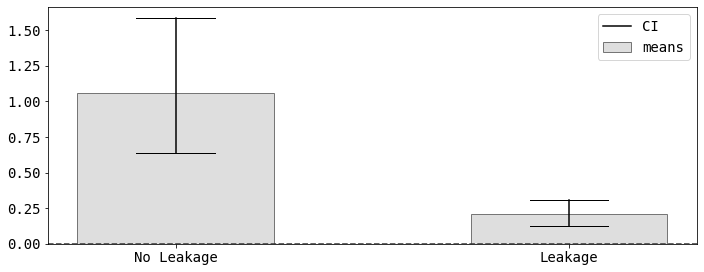

In [9]:
rho_x = 0.0
alpha = [1,1]
beta = [1,2]  # you can play with beta[1] and see the extent of the problem!
var_dict = dict()
var_dict['var_y'] = 1
var_dict['var_z'] = 1
nobs=100
seed = 64619
num_montecarlo = 300
df_mse1 = run_mc_leakage1(rho_x, alpha, beta, var_dict, nobs, seed, num_montecarlo)
fig, ax = plt.subplots()
ax = plot_mc_results(df = df_mse1, ax = ax, qmin=0.05, qmax=0.95)
ticks = ax.set_xticks([0,1])
labs = ax.set_xticklabels(['No Leakage', 'Leakage'])

## let's try to simulate a model where scaling on the whole sample induces leakage:
* Idea: $X,Y$ increases, so by standardizing with whole sample you give the model information about the larger $Y$

In [10]:
def scale_df(df, df_parent):
    "Standardize a given dataframe"
    mean = df_parent.mean()
    std_dev = df_parent.std()
    df_scaled = (df - mean)/std_dev
    mean_df = df_scaled.mean()
    std_df = df_scaled.std()
    #print(mean_df.max(), std_df.max())
    return df_scaled

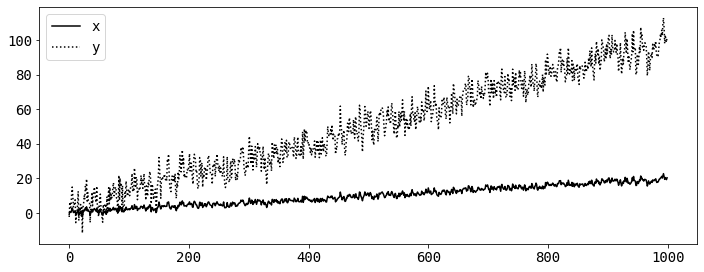

In [11]:
seed = 10315
nobs = 1000
a0, a1 = 1,5
var_y = 1
rho_x = 0.5
x = simulate_ar1_process(nobs=nobs, rho=rho_x, seed=seed, lab = 'x', trend = 0.01)
y = a0 + a1*x + np.sqrt(var_y)*np.random.randn(nobs,1)
y.rename(columns = {'x':'y'}, inplace=True)
fig, ax = plt.subplots()
x.plot(ax=ax)
y.plot(ax=ax, ls = 'dotted')

In [12]:
def split_given_point(xdf, ydf, t_split):
    "Train-test split given a time point"
    x_train, x_test = xdf.loc[xdf.index < t_split], xdf.loc[xdf.index >= t_split]
    y_train, y_test = ydf.loc[ydf.index < t_split], ydf.loc[ydf.index >= t_split]
    
    return x_train, x_test, y_train, y_test

x_train, x_test, y_train, y_test = split_given_point(xdf=x, ydf=y, t_split = int(nobs/2))
for v,var in enumerate([x_train, x_test, y_train, y_test]):
    print(v, var.shape)

0 (500, 1)
1 (500, 1)
2 (500, 1)
3 (500, 1)


In [13]:
def run_reg_mse(x_train, y_train, x_test, y_test):
    "Compute MSE after training OLS using training sample"
    ycol = y_train.columns
    reg = LinearRegression().fit(x_train, y_train)
    y_hat = reg.predict(x_test)
    mse = mean_squared_error(y_test, y_hat)

    return mse

In [14]:
mse_test = run_reg_mse(x_train, y_train, x_test, y_test)
mse_test

0.9462877264569868

In [15]:
def run_mc_leakage2(rho_x, alpha, var_y, nobs, trend, seed_mc, num_montecarlo):
    "MC to test the extent of leakage problem"
    np.random.seed(seed_mc)
    seed_arr = np.random.randint(low=1, high=10000, size=num_montecarlo, dtype=int)
    df_mse = pd.DataFrame(index=range(num_montecarlo), columns = ['mse_noleak', 'mse_leak'])
    a0, a1 = alpha
    for i in range(num_montecarlo):
        seed_i = seed_arr[i]
        x = simulate_ar1_process(nobs=nobs, rho=rho_x, seed=seed_i, lab = 'x', trend = trend)
        y = a0 + a1*x + np.sqrt(var_y)*np.random.randn(nobs,1)
        y.rename(columns = {'x':'y'}, inplace=True)
        # train-test split in t = 500
        x_train, x_test, y_train, y_test = split_given_point(xdf=x, ydf=y, t_split=int(nobs/2))
        # standardize with the complete data set --> leakage
        x_std_leak_tr, y_std_leak_tr  = scale_df(x_train, df_parent=x), scale_df(y_train, df_parent=y)
        x_std_leak_te, y_std_leak_te  = scale_df(x_test, df_parent=x), scale_df(y_test, df_parent=y)
        mse_leak = run_reg_mse(x_train = x_std_leak_tr, 
                               y_train = y_std_leak_tr, 
                               x_test = x_std_leak_te, 
                               y_test = y_std_leak_te)
        # without leakage:
        x_std_nl_tr, y_std_nl_tr  = scale_df(x_train, df_parent=x_train), scale_df(y_train, df_parent=y_train)
        x_std_nl_te, y_std_nl_te  = scale_df(x_test, df_parent=x_test), scale_df(y_test, df_parent=y_test)
        mse_nl = run_reg_mse(x_train = x_std_nl_tr, 
                               y_train = y_std_nl_tr, 
                               x_test = x_std_nl_te, 
                               y_test = y_std_nl_te)
        df_mse.loc[i] = [mse_nl, mse_leak]
    return df_mse

In [16]:
seed = 10315
nobs = 1000
alpha = [1,5]
var_y = 1
rho_x = 0.5
num_montecarlo = 300
mse_leak_trend = run_mc_leakage2(rho_x, alpha, var_y, nobs, seed_mc=seed, 
                                 trend = 0.01, num_montecarlo=num_montecarlo)
mse_leak_trend0 = run_mc_leakage2(rho_x, alpha, var_y, nobs, seed_mc=seed, 
                                 trend = 0.0, num_montecarlo=num_montecarlo)

Text(0, 0.5, 'MSE')

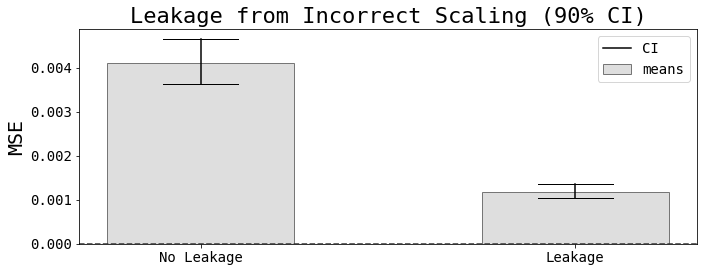

In [17]:
df_means = create_means_bounds_mc(df=mse_leak_trend, qmin = 0.05, qmax = 0.95)
means = df_means.loc['mean']
bounds = df_means.loc[[ix for ix in df_means.index if ix.find('percen')==0]].values
fig, ax = plt.subplots()
ax = plot_conf_intervals(means, bounds, var_labels=['No Leakage', 'Leakage'], ax=ax)
ax.set_title('Leakage from Incorrect Scaling (90% CI)')
ax.set_ylabel('MSE')

Text(0.5, 1.0, 'MSE With and Without Data Leakage (90% CI) - Scaling')

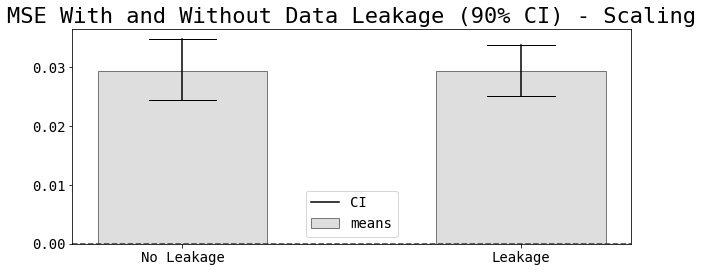

In [18]:
df_means = create_means_bounds_mc(df=mse_leak_trend0, qmin = 0.05, qmax = 0.95)
means = df_means.loc['mean']
bounds = df_means.loc[[ix for ix in df_means.index if ix.find('percen')==0]].values
fig, ax = plt.subplots()
ax = plot_conf_intervals(means, bounds, var_labels=['No Leakage', 'Leakage'], ax=ax)
ax.set_title('MSE With and Without Data Leakage (90% CI) - Scaling')

### Just in passing: let's show that AUC is sensitive to imbalanced datasets
* I mention this in the chapter, so let's document it

In [19]:
def simulate_lvc(alpha, nobs, sigma_eps, seed, thresh = 0.5):
    """
    Simulate latent variable classification model allowing for imbalanced outcomes
        For balanced: y = sign(alpha0 + alpha1*x +eps)
        For imbalanced: y = 1(alpha0 + alpha1*x + eps >= thresh)
    Inputs:
        alpha: parameters for latent variable
        nobs: number of observations in the dataset
        sigma_eps: variance for Normal disturbances
        seed: seed for random number generator
        thresh: quantile for setting threshold for defining y=1/0
    """
    np.random.seed(seed)
    x = np.random.randn(nobs)
    z = alpha[0] + alpha[1]*x + np.sqrt(sigma_eps)*np.random.randn(nobs)
    thresh_val = np.quantile(z,thresh)
    y = 1*(z<thresh_val)
    xdf = pd.DataFrame(x, columns = ['x'])
    ydf = pd.DataFrame(y, columns=['y'])
    return ydf, xdf

In [20]:
# Test this function to get imbalancedness
alpha = [0,1]
nobs = 100
sigma_eps=1
seed = 9053
ydf, xdf = simulate_lvc(alpha, nobs, sigma_eps, seed, thresh = 0.9)
print(f'% ones = {ydf.mean()}')
ydf, xdf = simulate_lvc(alpha, nobs, sigma_eps, seed, thresh = 0.5)
print(f'% ones = {ydf.mean()}')

% ones = y    0.9
dtype: float64
% ones = y    0.5
dtype: float64


In [21]:
def compute_auc(y_test, x_test, model):
    "Compute the AUC given a model and a test dataset"
    yhat_test = model.predict_proba(x_test)[:,1]
    fpr, tpr, thresh = metrics.roc_curve(y_true = y_test, y_score =  yhat_test)
    auc = metrics.auc(fpr, tpr)
    return auc

def run_mc_lvc(alpha, nobs, sigma_eps, seed_mc, num_montecarlo, thresh = 0.5):
    "Monte Carlo simulation for a latent variable classification model"
    np.random.seed(seed_mc)
    seed_arr = np.random.randint(low=1, high=10000, size=num_montecarlo, dtype=int)
    df_auc = pd.DataFrame(index=range(num_montecarlo), columns = ['logistic', 'gbc'])
    for i in range(num_montecarlo):
        seed_i = seed_arr[i]
        ydf, xdf = simulate_lvc(alpha, nobs, sigma_eps, seed=seed_arr[i], thresh = thresh)
        x_train, x_test, y_train, y_test = train_test_split(xdf, ydf, random_state=0)
        # Logistic Model
        lreg = LogisticRegression(random_state=0).fit(X=x_train, y=y_train.values.flatten())
        df_auc['logistic'].loc[i] = compute_auc(y_test, x_test, model=lreg)
        # GBC
        gbc = GradientBoostingClassifier(random_state=1159).fit(x_train, y_train.values.flatten())
        df_auc['gbc'].loc[i] = compute_auc(y_test, x_test, model=gbc)
        

    return df_auc

In [22]:
# ready to run simulation: do it with logistic results
alpha = [-2,1]
nobs = 200
num_montecarlo = 100
sigma_eps = 1
bal_grid = np.linspace(0.1,0.9,5)
seed_mc = 41219
df_auc_bal = pd.DataFrame(index = bal_grid, columns = ['auc'])
for b, bal in enumerate(bal_grid):
    df_b = run_mc_lvc(alpha, nobs, sigma_eps, seed_mc, num_montecarlo, thresh = bal)
    median_auc = df_b['logistic'].median()
    df_auc_bal['auc'].loc[bal] = median_auc

Text(0, 0.5, 'AUC')

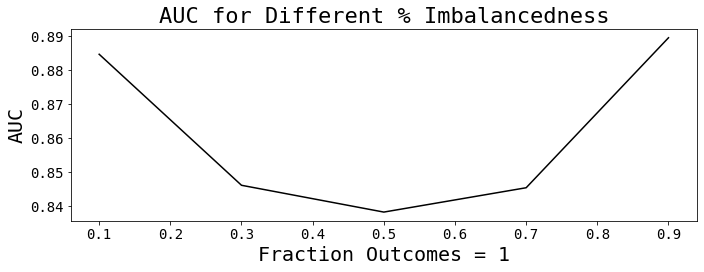

In [23]:
fig, ax = plt.subplots()
df_auc_bal.auc.plot(ax=ax)
ax.set_title('AUC for Different % Imbalancedness')
ax.set_xlabel('Fraction Outcomes = 1')
ax.set_ylabel('AUC')

# Complete and quasi-complete separation

In [24]:
# Simulate a simple model where we have complete separation!
# Note that the sign of X predicts perfectly the variable if you have a small enough number of observations
alpha = [0,1]
nobs = 10
sigma_eps=1
seed = 9053
ydf, xdf = simulate_lvc(alpha, nobs, sigma_eps, seed)
cat_df = pd.concat((ydf, xdf), axis=1)
cat_df['sign_x'] = 1*(cat_df.x>=0)
freq_df = 100*pd.crosstab(cat_df.y, cat_df.sign_x)/cat_df.shape[0]
freq_df

sign_x,0,1
y,,
0,0.0,50.0
1,50.0,0.0


In [26]:
# Note how the loglikelihood function is not defined!  This happens with Logistic Regression and is known as the
# Complete or Perfect Separation problem
# (-Loss Function is the LL function: 
#    see docs: https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression)
# The next example is taken from Davidson & MacKinnon (2004), Econometric Theory and Methods, Exercise: 11.5
alpha_arr = np.array([[0,1],[1,1],[-1,1],[0,2],[0,-2],[0,3]])
num_montecarlo = 30
seed_mc = 11315
nobs = 20
sigma_eps = 1
df_auc_log = pd.DataFrame(index=range(num_montecarlo), columns = [f'test{i}' for i in range(6)])
df_auc_gbc = pd.DataFrame(index=range(num_montecarlo), columns = [f'test{i}' for i in range(6)])
for t, test in enumerate(df_auc_gbc.columns):
    alpha_t = alpha_arr[t,:]
    df_t = run_mc_lvc(alpha_t, nobs, sigma_eps, seed_mc, num_montecarlo)
    df_auc_log[test] = df_t['logistic'].values
    df_auc_gbc[test] = df_t['gbc'].values    

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,


In [27]:
dict_meth = {0:df_auc_log, 1:df_auc_gbc}
dict_meth_lab = {0:'logistic', 1:'gbc'}
for i in range(2):
    df_i = dict_meth[i]
    freq_perf_auc = 100*(df_i==1).mean()
    predf = pd.DataFrame(100*df_i.isna().mean(), columns = ['pct_auc_nan'])
    predf['pct_auc_one'] = freq_perf_auc
    predf['method'] = dict_meth_lab[i]
    if i==0:
        df_auc_metrics = predf
    else:
        df_auc_metrics = pd.concat((df_auc_metrics, predf), axis=0)
df_metrics_agg = df_auc_metrics[['pct_auc_nan', 'pct_auc_one']].groupby(df_auc_metrics.method).median()
df_metrics_agg

,pct_auc_nan,pct_auc_one
method,,
gbc,3.333333,28.333333
logistic,3.333333,53.333333


In [28]:
# I don't want complete separation now
def simulate_qcs(alpha, nobs, sigma_eps, seed, frac_sep = 1, thresh = 0.5):
    """
    Simulate latent variable classification model allowing for imbalanced outcomes
        AND cuasi-complete separation (I choose)
        For balanced: y = sign(alpha0 + alpha1*x +eps)
        For imbalanced: y = 1(alpha0 + alpha1*x + eps >= thresh)
    Inputs:
        alpha: parameters for latent variable
        nobs: number of observations in the dataset
        sigma_eps: variance for Normal disturbances
        seed: seed for random number generator
        frac_sep: fraction for separation (if 1 you get a feature x3 that replicates y)
        thresh: quantile to generate outcome imbalancedness (float: in [0,1])
    """
    np.random.seed(seed)
    x1 = np.random.randn(nobs)
    x2 = np.random.randn(nobs)
    epsilon = np.sqrt(sigma_eps)*np.random.randn(nobs)
    z = alpha[0] + alpha[1]*x1 + alpha[2]*x2 + epsilon
    thresh_val = np.quantile(z,thresh)
    y = 1*(z<thresh_val)
    # I now want to sample from y to create a new feature x3
    # I will sample w/o replacement from the y=1's using frac_sep
    ydf = pd.DataFrame(y, columns=['y'])
    ix_ones = ydf[ydf.y==1].index
    num_ones = len(ix_ones)
    ix_x3 = np.random.choice(ix_ones, int(frac_sep*num_ones), replace=False)
    x3 = pd.Series([0]*nobs, index = range(nobs), name= 'x3')
    x3.loc[ix_x3] = 1
    # arrange everything in dataframes
    xdf = pd.DataFrame(x1, columns = ['x1'])
    xdf['x2'] = x2
    xdf['x3'] = x3
    return ydf, xdf

In [29]:
def run_mc_qcs(alpha, nobs, sigma_eps, seed_mc, num_montecarlo, frac_sep = 1, thresh = 0.5):
    """Monte Carlo simulation for a latent variable classification model
        with quasi complete separation
    """
    np.random.seed(seed_mc)
    seed_arr = np.random.randint(low=1, high=10000, size=num_montecarlo, dtype=int)
    df_auc = pd.DataFrame(index=range(num_montecarlo), columns = ['logistic', 'gbc'])
    for i in range(num_montecarlo):
        seed_i = seed_arr[i]
        ydf, xdf = simulate_qcs(alpha, nobs, sigma_eps, seed=seed_i, frac_sep = frac_sep)
        x_train, x_test, y_train, y_test = train_test_split(xdf, ydf, random_state=0)
        # Logistic Model
        lreg = LogisticRegression(random_state=0).fit(X=x_train, y=y_train.values.flatten())
        df_auc['logistic'].loc[i] = compute_auc(y_test, x_test, model=lreg)
        # GBC
        gbc = GradientBoostingClassifier(random_state=1159).fit(x_train, y_train.values.flatten())
        df_auc['gbc'].loc[i] = compute_auc(y_test, x_test, model=gbc)
        

    return df_auc

In [30]:
# Test this new function:
# Note that x3=1 gets complete separation (x3=0 has both y=0, y=1)
alpha = [1,1,1]
nobs = 100
sigma_eps=1
seed = 9053
ydf, xdf = simulate_qcs(alpha, nobs, sigma_eps, seed, frac_sep = 0.5, thresh = 0.5)
print(f'% ones = {ydf.mean()}')
catyx = pd.concat((ydf, xdf), axis=1)
pd.crosstab(catyx.x3, catyx.y)

% ones = y    0.5
dtype: float64


y,0,1
x3,,
0,50,25
1,0,25


In [31]:
alpha= [1,1,1]
num_montecarlo = 300
seed_mc = 86115
nobs = 100
sigma_eps = 1
G = 10
grid_sep = np.linspace(0,1,G)
df_auc_log_sep = pd.DataFrame(index=range(num_montecarlo), columns = grid_sep)
df_auc_gbc_sep = pd.DataFrame(index=range(num_montecarlo), columns = grid_sep)
for s, sep in enumerate(grid_sep):
    df_s = run_mc_qcs(alpha, nobs, sigma_eps, seed_mc, num_montecarlo, frac_sep = sep, thresh = 0.5)
    df_auc_log_sep[sep] = df_s['logistic'].values
    df_auc_gbc_sep[sep] = df_s['gbc'].values    

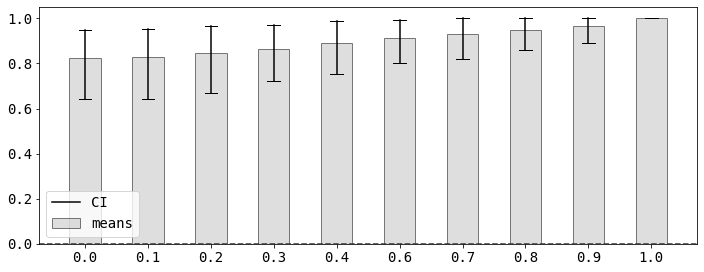

In [32]:
fig, ax = plt.subplots()
ax = plot_mc_results(df = df_auc_gbc_sep, ax = ax, qmin=0.05, qmax=0.95)
ticks = ax.set_xticks(range(G))
labs = ax.set_xticklabels([fr.round(decimals=1) for fr in grid_sep])

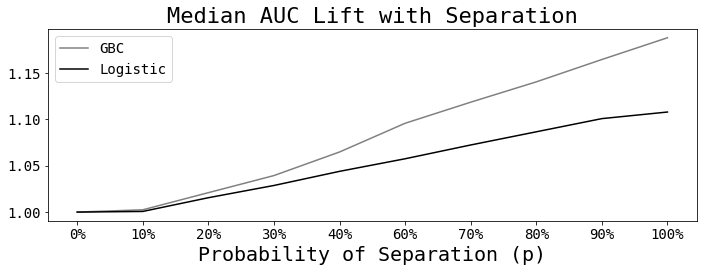

In [33]:
fig, ax = plt.subplots()
ix_nice = [f'{int(100*gr.round(decimals=1))}%' for gr in grid_sep]
med_auc = pd.DataFrame(df_auc_gbc_sep.median().values, index = ix_nice, columns = ['gbc'])
med_auc['logistic'] = df_auc_log_sep.median().values
# normalize the AUC wrt the case of no separation
med_auc = med_auc.div(med_auc.loc[med_auc.index[0]], axis =1)
med_auc.plot(ax=ax, color = ['0.5', '0.0'])
ax.legend(['GBC', 'Logistic'])
ax.set_title('Median AUC Lift with Separation')
ax.set_xlabel('Probability of Separation (p)')
ticks = ax.set_xticks(range(G))
labs = ax.set_xticklabels(ix_nice)

### Example of a query to enforce time windows

In [101]:
import datetime
from dateutil.relativedelta import relativedelta
def query_data(len_obs, len_pre):
    """
    Function to query the data enforcing the chosen time windows.
        Requires a connection to the company's database
    Inputs:
        len_obs: integer: length in months for obsevation window (O)
        len_pre: integer: length in months for prediction window (P)
    Outputs:
        df: pandas dataframe with data for training the model
    """
    # set the time variables
    today = datetime.datetime.today()
    base_time = today - relativedelta(months = len_pre)  # t_p - P
    init_time = base_time - relativedelta(months = len_obs)
    end_time = base_time + relativedelta(months = len_pre)
    init_str = init_time.strftime('%Y-%m-%d')
    base_str = base_time.strftime('%Y-%m-%d')
    end_str = end_time.strftime('%Y-%m-%d')
    print(f'Observation window (O={len_obs}): [{init_str}, {base_str}) \\\
            \nPrediction window (P={len_pre}): = [{base_str}, {end_str}]') 
    # create query
    my_query = f"""
      SELECT 
          SUM(CASE WHEN date >= '{init_str}' AND date < '{base_str}' THEN x_metric ELSE 0 END) AS my_feature,
          SUM(CASE WHEN date >= '{base_str}' AND date <= '{end_str}' THEN y_metric ELSE 0 END) AS my_outcome
      FROM my_table
    """
    print(my_query)
    # connect to database and bring in the data 
    df = connect_to_database(my_query, conn_parameters)  #will throw error since the method doesn't exist
    return df

In [102]:
print(query_data(len_obs=3, len_pre=1))

Observation window (O=3): [2022-11-16, 2023-02-16) \            
Prediction window (P=1): = [2023-02-16, 2023-03-16]

      SELECT 
          SUM(CASE WHEN date >= '2022-11-16' AND date < '2023-02-16' THEN x_metric ELSE 0 END) AS my_feature,
          SUM(CASE WHEN date >= '2023-02-16' AND date <= '2023-03-16' THEN y_metric ELSE 0 END) AS my_outcome
      FROM my_table
    


NameError: name 'connect_to_database' is not defined